 ** Figure 6: Machine-learning based detection of EwS and distinction from other sarcomas **

Here, we are using a table ("ML_input_features.xlsx") containing all the features required as input, including features from global fragmentation, regional fragmentation & read depth, as well as features based on fragment coverage at EwS-specific DHSs. How these metrics were generated is outlined in the previous notebooks.

In [ ]:
%%bash
wget http://medical-epigenomics.org/papers/peneder2020_f17c4e3befc643ffbb31e69f43630748/data/ML_input_features.xlsx

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import sys
import os
sys.path.insert(0, os.getcwd())
import binary_classifier_considering_patients as binary_classifier
import subprocess
from datetime import datetime
from sklearn.linear_model import LinearRegression
import pickle

In [3]:
# settings
max_threads=10
max_mem=100
myseed=42
metalearn=True
run_baselearners=True
skip_baselearn_if_present=True
n_bootstrap_reps=10

In [4]:
# This function is used in all ML experiments and calls the training and testing procedure for all 4 feature sets and the metalearner,
# for a given set of samples and a given response
# The actual training and testing is in 
def run_classification(name, traintestset, unclear_set, response, response_name,alternative_reference_for_unclears,alternative_response_name,
                       n_bootstrap_reps=n_bootstrap_reps):
         
    if not os.path.exists(name):
        os.mkdir(name)
    os.chdir(name)
       
    for predictors_w_names_and_metalearnername in  [("METALEARNER_fullx",predictorset_fullx),
                                                    ("METALEARNER_1x",predictorset_1x),
                                                    ("METALEARNER_0.1x", predictorset_0point1x)]:
        
        predictors_w_names=predictors_w_names_and_metalearnername[1]
        metalearn_dirname=predictors_w_names_and_metalearnername[0]
        
        # saves the predictions of each classifier for metalearning
        p1_dict={"traintestset":pd.DataFrame(),"unclearset":pd.DataFrame()}
        predictornames_for_metalearning_w_mean_p1=[]
        # saves the prediction of each classifier - only using samples in the trainingset
        trainingsetbased_p1=pd.DataFrame()

        for predictorelem in predictors_w_names:
            predictors=predictorelem[1]
            predictor_name=predictorelem[0]
            print("Running for",predictor_name)
            if not os.path.exists(predictor_name):
                os.mkdir(predictor_name)
            os.chdir(predictor_name)

            if run_baselearners and not (skip_baselearn_if_present and os.path.isfile("bestmodel_classification_out_of_sample_predictions_"+name+".csv")):
                cols=(predictors+["sample","patient",response]+([alternative_reference_for_unclears] if not alternative_reference_for_unclears in predictors else []))
                
                # run the actual classification using the given set of features
                binary_classifier.run_classification(comparisonname=name,df=pd.concat([traintestset,unclear_set],axis=0)[cols],
                                                     labelsamples=list(traintestset["sample"]),
                                                     unclearsamples=list(unclear_set["sample"]),
                                                     response=response,predictors=predictors, response_name=response_name,
                                                     alternative_reference_for_unclears=alternative_reference_for_unclears,
                                                     alternative_response_name=alternative_response_name,
                                                     n_bootstrap_reps=n_bootstrap_reps,max_threads=max_threads,max_mem=max_mem)

            # save the resulting predictions of this classifier in the table such that it can be used by the meta-learner
            trainingsetbased_p1_thisclassifier=pd.read_csv("trainingset_based_predictions_for_metalearner.csv")
            trainingsetbased_p1_thisclassifier=trainingsetbased_p1_thisclassifier.rename({x:predictor_name+x for x in trainingsetbased_p1_thisclassifier.columns if not x=="sample"},axis=1)
            if trainingsetbased_p1.empty:
                trainingsetbased_p1=trainingsetbased_p1_thisclassifier
            else:
                trainingsetbased_p1=pd.merge(trainingsetbased_p1,trainingsetbased_p1_thisclassifier,left_on="sample",right_on="sample",how="inner")
  
            os.chdir('..')

        ## metalearning :
        if metalearn:
            metainput=pd.merge(pd.concat([traintestset,unclear_set]),trainingsetbased_p1,left_on="sample",right_on="sample",how="inner")
            metapreds=[x for x in trainingsetbased_p1.columns if not x=="sample"]

            if not os.path.exists(metalearn_dirname):
                os.mkdir(metalearn_dirname)
            else:
                print("Metalearning already done. skipping")
                continue
            os.chdir(metalearn_dirname)
            
            # run the actual classification using the predictions of the previously run classifiers as input features
            binary_classifier.run_classification(comparisonname=name,df=metainput,
                                                 labelsamples=list(traintestset["sample"]),
                                                 unclearsamples=list(unclear_set["sample"]),
                                                 response=response,predictors=metapreds,
                                                 response_name=response_name,
                                                 alternative_reference_for_unclears=alternative_reference_for_unclears,
                                                 alternative_response_name=alternative_response_name,
                                                 n_bootstrap_reps=n_bootstrap_reps,max_threads=max_threads,
                                                 metalearn=True)
            os.chdir('..')
    os.chdir('..')
        
        
def run_w_shuffled_lables(workdir,traintestset,response,nr_outerouter_folds_start,nr_outerouter_folds_end,name):
    ### with shuffled labels:
    os.makedirs(workdir,exist_ok=True)
    os.chdir(workdir)
    os.makedirs("RANDOMIZED_labels_traintestset",exist_ok=True)
    os.chdir("RANDOMIZED_labels_traintestset")

    for i in range(nr_outerouter_folds_start,nr_outerouter_folds_end+1):
        np.random.seed(seed=myseed+1000+i)
        os.makedirs(str(i),exist_ok=True)
        os.chdir(str(i))
        shuffledtraintestset=traintestset.assign(**{response:np.random.permutation(traintestset[response].values)})
        unclear_set=df[~df["sample"].isin(shuffledtraintestset["sample"])]
        unclear_set=unclear_set.assign(**{response:np.nan})
        run_classification(name=name,traintestset=shuffledtraintestset,
                           unclear_set=unclear_set,response=response,response_name="RANDOM"+response,
                           alternative_reference_for_unclears="is_genomic_tumor_evidence_available",
                           alternative_response_name="Genomic tumor evidence available",n_bootstrap_reps=1)
        os.chdir("..")
    os.chdir("../.." if not workdir=="." else "..")

In [ ]:
# load data
df=pd.read_excel("ML_input_features.xlsx")

# Define the feature-sets for each of the coverage levels 12x, 1x, and 0.1x
# to keep things simple, lists containing the feature-sets are already pickled and just loaded here:
with open("predictorset_fullx.pickle", "rb") as fp:
    predictorset_fullx=pickle.load(fp)
with open("predictorset_1x.pickle", "rb") as fp:
    predictorset_1x=pickle.load(fp)
with open("predictorset_0point1x.pickle", "rb") as fp:
    predictorset_0point1x=pickle.load(fp)
df_all=df.copy()
df=df[df["Sample type"]!="Non-EwS sarcoma"]

# Define control sets
our_controls=df[df["sample"].str.contains("Ctrl")]
crist_controls=df[df["sample"].str.contains("EGAR")]
ulz_ctrls=df[df["sample"].str.contains("NPH")]
controls=pd.concat([our_controls,crist_controls,ulz_ctrls],axis=0)
non_ews_cancers=df[df["Sample type"]=="Non-EwS sarcoma"]


# Start the ML experiments
if True:
    ##### Clinical evidence for tumor: YES vs. healthy CTRLs (seperately for each control set) #####
    for controlsetname, controlset in [("our_ctrls_only",our_controls),("crist_ctrl_only",crist_controls),("ulz_ctrl_only",ulz_ctrls)]:

        os.makedirs(controlsetname,exist_ok=True)
        os.chdir(controlsetname)
        response="clinical data indicating presence of tumor (PET-SCAN, MRI, CT)"
        clinical_evidence_yes=df[df[response]=="yes"]
        clinical_evidence_yes=clinical_evidence_yes.assign(**{response:1})
        controlset=controlset.assign(**{response:0})
        traintestset=pd.concat([clinical_evidence_yes,controlset],axis=0)
        unclear_set=df[~df["sample"].isin(traintestset["sample"])]
        unclear_set=unclear_set.assign(**{response:np.nan})
        name="Clinical_evidence_for_tumor_YES__vs__healthy_CTRLs"
        run_classification(name=name,traintestset=traintestset,
                          unclear_set=unclear_set,response=response,response_name="Clinical tumor evidence",
                          alternative_reference_for_unclears="is_genomic_tumor_evidence_available",
                          alternative_response_name="Genomic tumor evidence available",
                          n_bootstrap_reps=n_bootstrap_reps)
        os.chdir("..")

if False:
    ##### OUR vs CRISTIANO CTRLS #####
    response="is_crist_ctrl"
    crist_controls1=crist_controls.assign(**{response:1})
    our_controls1=our_controls.assign(**{response:0})
    traintestset=pd.concat([our_controls1,crist_controls1],axis=0)
    unclear_set=df[~df["sample"].isin(traintestset["sample"])]
    unclear_set=unclear_set.assign(**{response:np.nan})
    name="is_crist_ctrl"
    run_classification(name=name,traintestset=traintestset,
                       unclear_set=unclear_set,response=response,response_name="Is cristiano et al ctrl",
                       alternative_reference_for_unclears="is_genomic_tumor_evidence_available",
                       alternative_response_name="Genomic tumor evidence available")
if False:
    ##### OUR vs ULZ CTRLS #####
    response="is_ulz_ctrl"
    ulz_controls2=ulz_ctrls.assign(**{response:1})
    our_controls2=our_controls.assign(**{response:0})
    traintestset=pd.concat([our_controls2,ulz_controls2],axis=0)
    unclear_set=df[~df["sample"].isin(traintestset["sample"])]
    unclear_set=unclear_set.assign(**{response:np.nan})
    name="is_ulz_ctrl"
    run_classification(name=name,traintestset=traintestset,
                       unclear_set=unclear_set,response=response,response_name="Is ulz et al ctrl",
                       alternative_reference_for_unclears="is_genomic_tumor_evidence_available",
                       alternative_response_name="Genomic tumor evidence available")

if False:
    #### Diagnostic EwS vs Ctrls from this study
    response="is_diag_EwS"
    diag=df[df["sample timepoint"]=="diagnosis"]
    diag=diag.assign(**{response:1})
    controls_for_this_experiment=our_controls.assign(**{response:0})
    traintestset=pd.concat([diag,controls_for_this_experiment],axis=0)
    unclear_set=df[~df["sample"].isin(traintestset["sample"])]
    unclear_set=unclear_set.assign(**{response:np.nan})
    name="diagnostic_EwS_vs_healthy"
    run_classification(name=name,traintestset=traintestset,
                       unclear_set=unclear_set,response=response,response_name="Diagnostic EwS sample",
                       alternative_reference_for_unclears="is_genomic_tumor_evidence_available",
                       alternative_response_name="Genomic tumor evidence available")
    os.chdir("..")
    
if False:
    ##### EwS vs non-EwS samples  - both with genomic evidence for tumor ######
    response="is_ewing_w_gen_evidence_not_nonewingcancerinclEwslike_w_gen_evidence"
    ews_genomic_evidence_yes=df[df["is_genomic_tumor_evidence_available"]==1]
    ews_genomic_evidence_yes=ews_genomic_evidence_yes.assign(**{response:1})
    nonews_cancer=df_all[(df_all["sample"].isin(non_ews_cancers))].assign(**{response:0})
    nonews_genomic_evidence_yes=nonews_cancer[nonews_cancer["is_genomic_tumor_evidence_available"]==1]
    nonews_genomic_evidence_yes=nonews_genomic_evidence_yes.assign(**{response:0})
    traintestset=pd.concat([ews_genomic_evidence_yes,
                            nonews_genomic_evidence_yes],axis=0)
    unclear_set=df[~df["sample"].isin(traintestset["sample"])]
    unclear_set=unclear_set.assign(**{response:np.nan})
    unclear_set=unclear_set.assign(**{"dummy":np.nan})
    name="ewing_w_gen_evidence_not_nonewingcancerinclEwslike_w_gen_evidence"
    run_classification(name=name,traintestset=traintestset,
                       unclear_set=unclear_set,response=response,response_name="Is EwS sample w. tumor ev., not other cancer w. tumor ev.",
                       alternative_reference_for_unclears="dummy",
                       alternative_response_name="No information available")

In [36]:
## To summarize the performance of different classifiers in one plot:

import sklearn
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.metrics import roc_curve, precision_recall_curve, auc,average_precision_score
import pandas as pd
from scipy import interp
import numpy as np
from collections import defaultdict
import sys
import glob
from matplotlib import rc
rc('font',**{'sans-serif':['Arial']})
np.seterr(all='raise')


def plot_ROC_curves(outname, response, csvname,n_bootstrap_its, featureset_paths_and_names,combine_controlsets=True,
use_only_ulz_ctrls=False,
use_only_cristiano_ctrls=False,
use_only_our_ctrls=False,sort_by_AUC=True,restrict_to_these_testset_ews_samples=None):
    
    plt.gcf().set_size_inches(4,4)

    table_text=[]
    rownames=[]
    colors=[]
    tabledict={}

    color_base=["cadetblue","coral","mediumseagreen","firebrick","#9467bd"]
    def get_color(name):
        if "Global" in name:
            return color_base[0]
        if "DHS" in name:
            return color_base[1]
        if  "depth" in name:
            return color_base[2]
        if "Regional" in name:
            return color_base[3]
        if "Meta" in name:
            return color_base[4]
        else:
            return "black"

    for j in range(0,len(featureset_paths_and_names),2): # for every feature-set (folder name and label)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 10000)
        mean_sensitivity_at_100spec=[]
        mean_sensitivity_at_95spec=[]
        name=(featureset_paths_and_names[j+1]).replace("__","\n")

        parentname=csvname.replace("bestmodel_classification_out_of_sample_predictions_","").replace(".csv","")

        print(featureset_paths_and_names[j])
        if combine_controlsets==False and use_only_our_ctrls==False:
            df_our=pd.DataFrame()
        else:
            df_our=pd.read_csv("our_ctrls_only/"+parentname+"/"+featureset_paths_and_names[j]+"/%s"%(csvname))[[response,"sample"]+["%s_p1"%(idx) for idx in range(n_bootstrap_its)]]
        if combine_controlsets==False and use_only_cristiano_ctrls==False:
            df_crist=pd.DataFrame()
        else:
            df_crist=pd.read_csv("crist_ctrl_only/"+parentname+"/"+featureset_paths_and_names[j]+"/%s"%(csvname))[[response,"sample"]+["%s_p1"%(idx) for idx in range(n_bootstrap_its)]]
        if combine_controlsets==False and use_only_ulz_ctrls==False:
            df_ulz=pd.DataFrame()
        else:
            df_ulz=pd.read_csv("ulz_ctrl_only/"+parentname+"/"+featureset_paths_and_names[j]+"/%s"%(csvname))[[response,"sample"]+["%s_p1"%(idx) for idx in range(n_bootstrap_its)]]

        if combine_controlsets==True: # here, the results from the different control sets are averaged in a meta-analysis approach

            # simply rename the columns of the cristiano and ulz datasets to higher iteration numbers to keep them apart from the other datasets
            df_crist.columns=[response,"sample"]+["%s_p1"%(idx) for idx in range(n_bootstrap_its,n_bootstrap_its*2)]
            df_ulz.columns=[response,"sample"]+["%s_p1"%(idx) for idx in range(n_bootstrap_its*2,n_bootstrap_its*3)]
            sampleset=set()
            for i in range(n_bootstrap_its*3):
                if i>=n_bootstrap_its*2:
                    df=df_ulz
                elif i>=n_bootstrap_its:
                    df=df_crist
                else:
                    df=df_our
                testset=df.dropna(subset=[str(i)+"_p1"],axis=0) # keep only samples that were in the testset in this fold
                if restrict_to_these_testset_ews_samples:
                    testset=testset[(testset[response]==0) | (testset["sample"].isin(restrict_to_these_testset_ews_samples))]
                    sampleset.update(set(testset[testset[response]==1]["sample"].values))

                # Get the roc curve and auc of this fold:
                #https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
                fpr, tpr, thresholds = roc_curve([int(x) for x in testset[response].values], testset[str(i)+"_p1"].values)
                tprs.append(interp(mean_fpr, fpr, tpr))
                mean_sensitivity_at_100spec.append(interp(mean_fpr, fpr, tpr)[0])
                mean_sensitivity_at_95spec.append(max([tpr_val for tpr_val,fpr_val in zip(tpr,fpr) if fpr_val<0.05]))# interp(mean_fpr, fpr, tpr)[0])

                tprs[-1][0] = 0.0
                roc_auc = auc(fpr, tpr)
                aucs.append(roc_auc)
        elif combine_controlsets==False: # Here, the results from only on control set are used
            sampleset=set()
            df=df_our.append(df_crist,sort=True)
            df=df.append(df_ulz,sort=True)
            for i in range(n_bootstrap_its):
                testset=df.dropna(subset=[str(i)+"_p1"],axis=0) # keep only samples that were in the testset in this fold
                if restrict_to_these_testset_ews_samples:
                    testset=testset[(testset[response]==0) | (testset["sample"].isin(restrict_to_these_testset_ews_samples))]
                    sampleset.update(set(testset[testset[response]==1]["sample"].values))

                # Get the roc curve and auc of this fold:
                fpr, tpr, thresholds = roc_curve([int(x) for x in testset[response].values], testset[str(i)+"_p1"].values)
                tprs.append(interp(mean_fpr, fpr, tpr))
                mean_sensitivity_at_100spec.append(interp(mean_fpr, fpr, tpr)[0])
                mean_sensitivity_at_95spec.append(max([tpr_val for tpr_val,fpr_val in zip(tpr,fpr) if fpr_val<0.05]))# interp(mean_fpr, fpr, tpr)[0])
                tprs[-1][0] = 0.0
                roc_auc = auc(fpr, tpr)
                aucs.append(roc_auc)

        # Average over all folds:
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        CI_auc = "%0.2f-%0.2f"%(np.percentile(aucs,2.5),np.percentile(aucs,97.5))
        CI_sens_100_spec= "%0.2f-%0.2f"%(np.percentile(mean_sensitivity_at_100spec,2.5),np.percentile(mean_sensitivity_at_100spec,97.5))

        # plot the averaged ROC curve
        p=plt.plot(mean_fpr,mean_tpr, lw=2, color=get_color(name), alpha=.7)
        # and add statistics to the table
        this_table_text=["%0.2f (%s)"%(mean_auc,CI_auc),"%0.2f (%s)"%(np.mean(mean_sensitivity_at_100spec), CI_sens_100_spec)]
        rownames.append(name)
        colors.append(get_color(name))
        tabledict[name]={"text":this_table_text,"color":get_color(name),"rank":1-mean_auc}
        print(np.mean(mean_sensitivity_at_95spec))


    plt.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='grey',
             label='Chance', alpha=.8)
    colwidth=0.2
    bbox=[0.51,0.02,0.537,0.4]
    if sort_by_AUC:
        tabledict={k:v for k,v in sorted(tabledict.items(),key=lambda item: item[1]["rank"])}
    table_text=[v["text"] for v in tabledict.values()]
    rownames=list(tabledict.keys())
    colors=[v["color"] for v in tabledict.values()]

    table=plt.table(cellText=table_text,rowLabels=["—" for x in rownames],colLabels=["ROC\nAUC\n\nmean     (CI)     ","Sens. at\n100% spec.\n\nmean      (CI)      "],rowColours=colors,rowLoc="center",cellLoc="center",bbox=bbox,colWidths=[0.25,0.25])

    table.auto_set_font_size(False)
    table.set_fontsize(7)

    cellDict= table.get_celld()

    # columns
    for i in [0,1]:

        # column labels
        cellDict[(0,i)].set_color("white")
        cellDict[(0,i)].set_edgecolor(None)
        cellDict[(0,i)].set_linewidth(2)
        cellDict[(0,i)].set_alpha(1)
        cellDict[(0,i)].set_height(0.067)
        cellDict[(0,i)].set_text_props(weight="bold",color="black")


        for j in range(1,len(range(0,len(featureset_paths_and_names),2))+1): # rows
            # row labels:
            cellDict[(j,-1)].set_alpha(1)
            cellDict[(j,-1)].set_text_props(weight="bold",color="white")
            cellDict[(j,-1)].set_edgecolor(None)
            cellDict[(j,-1)].set_linewidth(0)
            cellDict[(j,-1)].set_color("white")#("#f2f2f2")
            cellDict[(j,-1)].set_height(0.03)
            cellDict[(j,-1)].set_text_props(weight=1000,color=colors[j-1],fontproperties=FontProperties(size=15))

            # entries
            cellDict[(j,i)].set_color("white")#("#f2f2f2")
            cellDict[(j,i)].set_edgecolor(None)
            cellDict[(j,i)].set_linewidth(0)
            cellDict[(j,i)].set_height(0.03)
            cellDict[(j,i)].set_alpha(1)#(0.9)
            cellDict[(j,i)].set_text_props(fontproperties=FontProperties(size=7))

    for cell in table._cells:
        table._cells[cell].set_edgecolor(None)
        table._cells[cell].set_linewidth(0)


    plt.xlim([-.01, 1])
    plt.ylim([-0, 1])
    plt.xlabel('False-positive fraction')
    plt.ylabel('True-positive fraction')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.gcf().savefig(outname)
    plt.show()

coverage_at_EwS_DHS
0.7235142118863049
global_fragment_size
0.8863049095607235
read_depth_5mb
0.9397071490094746
regional_fragmentation_5mb
0.9698535745047372
METALEARNER_fullx
0.9698535745047372


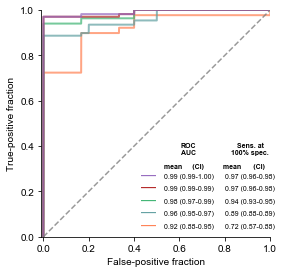

In [37]:
# Example of ROC curve calculation (here only for 2 bootstrap iterations for quick calculation):
plot_ROC_curves("test.pdf",
                'clinical data indicating presence of tumor (PET-SCAN, MRI, CT)',
                'bestmodel_classification_out_of_sample_predictions_Clinical_evidence_for_tumor_YES__vs__healthy_CTRLs.csv',
                2,
                ["coverage_at_EwS_DHS",'Coverage at__Ews-specifc DHSs',
                 "global_fragment_size","Global fragment__size distribution",
                 "read_depth_5mb",'Read depth__in 5 Mb bins',
                 "regional_fragmentation_5mb",'Regional fragmentation__patterns',
                 "METALEARNER_fullx", "Metalearner"],
               combine_controlsets=False,use_only_our_ctrls=True)